# Train a U-Net for Cell Segmentation
To segment the full cell (cytosol + nucleus) we first train a U-Net to predict the foreground and boundaries of the cells. We will later uses these predictions to segment the cells using a seeded watershed from the nucleus predictions (see previous notebooks).

Here, we will use the pytorch library to train a U-Net using the images and ground-truth data we have downloaded. The goal of this lesson is learning how to use this library for training segmentation models.

Note: we are also working on a notebook that shows how to train a U-Net using only PyTorch in pytorch_train-cell-membrane-segmentation.ipynb. (This is not yet finished.)

In [1]:
# General imports.

import os
import sys
from glob import glob
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import napari
import numpy as np

sys.path.append("..")
import utils

In [2]:
# This function will download and unpack the data and do some further data preparation.
# It will only be executed if the data has not been downloaded yet.
data_dir = "../data"
if os.path.exists(data_dir):
    print("The data is downloaded already.")
else:
    utils.prepare_data(data_dir)

The data is downloaded already.


### 1. Prepare the data for training

In [3]:
# The data has been downloaded and separated into folders for the train, validation and test split already.
# We first create a dictionary with the location of the three different split folders.
data_dirs = {
    "train": os.path.join(data_dir, "train"),
    "val": os.path.join(data_dir, "val"),
    "test": os.path.join(data_dir, "test")
}

# And check the content for one of the samples.
# After the print you should see the images (marker, nuclei, serum), labels (cells and nuclei) as well as a json file.
train_sample0 = os.path.join(data_dirs["train"], "gt_image_000")
print(os.listdir(train_sample0))

['labels.json', 'gt_image_000_marker_image.tif', 'gt_image_000_cell_labels.tif', 'gt_image_000_nucleus_labels.tif', 'gt_image_000_serum_image.tif', 'gt_image_000_infected_labels.tif', 'gt_image_000_nucleus_image.tif']


In [4]:
# Here we define the function that cuts out the small images centered around the cells for one image.

# This is a helper function for normalizing an image to the range [0, 1].
# Data normalization is important when training neural networks for image data
# to make sure all the inputs are in the same data range.
def normalize(image):
    image = image.astype("float32")
    # Normalise the image to [0,1]
    image = (image - np.min(image))/np.ptp(image)
    return image


# This is the main function for extracting the small images.
# We give it the path to the folder containing the data for a sample as input.
# Remember that this contains the images, segmentations and classification data
# in individual files for each sample. We have explored some of this data above.
def extract_images_and_labels(sample_folder):

    # We create the filepaths for the image and segmentation data we will load. 
    sample_name = os.path.basename(sample_folder)  # We can derive the sample name from the foldername.

    # serum is the image and cell is the label
    serum_path = os.path.join(sample_folder, f"{sample_name}_serum_image.tif")
    cell_segmentation_path = os.path.join(sample_folder, f"{sample_name}_cell_labels.tif")

    # And load the serum image and the cell segmentation.
    # We normalize the serum image so that the data range is in [0, 1].
    serum = normalize(imageio.imread(serum_path))
    # Note that we must not normalize the segmentation!
    cells = imageio.imread(cell_segmentation_path)

    return serum, cells

In [5]:
# This function applies the data extraction function we just defined to all samples
# for a split (training, validation or test) and extracts all the corresponding small images
# and classification labels.
def prepare_split(split):
    # Get all the folders for the samples of this split.
    split_folder = data_dirs[split]
    samples = glob(os.path.join(split_folder, "gt*"))
    # Iterate over all the samples and extract the images and labels from them.
    images, labels = [], []
    for sample in samples:
        sample_image, sample_labels = extract_images_and_labels(sample)
        images.append(sample_image)
        labels.append(sample_labels)
    return images, labels

In [6]:
# Now we apply the functions for the training, validation and test split
# and check how many samples we have for each split.

train_images, train_labels = prepare_split("train")
print("We have", len(train_images), "training samples.")

We have 35 training samples.


In [7]:
val_images, val_labels = prepare_split("val")
print("We have", len(val_images), "validation samples")

We have 5 validation samples


In [8]:
test_images, test_labels = prepare_split("test")
print("We have", len(test_images), "test samples")

We have 9 test samples


In [10]:
viewer = napari.Viewer()
# Visualize the image data
viewer.add_image(train_images[0], colormap="green")
viewer.add_labels(train_labels[0])

/home/pape/micromamba/envs/main/lib/python3.11/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)


<Labels layer 'Labels' at 0x7f4321c54e50>

### 2. Build dataset, dataloader and model

In [10]:
# Import the PyTorch functionality we need.
import torch
from torch.utils.data import Dataset, DataLoader

import tqdm
import torch.nn as nn
import torch.nn.functional as F

# Additional imports for evaluation and image transformations.
from torchvision.transforms import v2
from sklearn import metrics
from skimage.transform import resize

/opt/conda/envs/sam/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/envs/sam/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in t

In [11]:
# We first check if we have access to a GPU.
# The model training will be much faster if we can use a GPU.
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. The training will be very slow!")
    device = torch.device("cpu")

GPU is available


In [12]:
# To provide the data for training we need to create a PyTorch Dataset.
# Datasets provide a single example (= small image + label) for training.
# They can also be used to process the data further. Here, we resize the images
# to the common shape within the dataset.

# You can find more information on datasets here:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

# To create a dataset for our task we create a class that inherits
# from the PyTorch dataset.
class CustomDataset(Dataset):
    # Here we define the data for creating the dataset:
    # The small images for this dataset, the labels and the size for reshaping the images.
    def __init__(self, images, labels, crop_size, transform=None, mask_transform=None):
        self.images = images
        self.labels = labels
        self.crop_size = crop_size
        self.transform = transform
        self.mask_transform = mask_transform

    # A dataset needs a __len__ method that returns how many samples are in the dataset.
    # Here, the number of samples corresponds to the number of small images.
    def __len__(self):
        return len(self.images)

    # The __getitem__ method returns the image data and labels for a given sample index.
    def __getitem__(self, index):
        # Load the image data and label for this sample index.
        image = self.images[index]
        mask = self.labels[index]

        # crop the images, so that we can fit them into memory
        crop_shape = self.crop_size
        shape = image.shape
        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            # bring it to common shape
            image = resize(image, shape, preserve_range=True)
            mask = resize(mask, shape, preserve_range=True)
            # Random crop same excerpt from image and mask
            i, j, h, w = v2.RandomCrop.get_params(
                torch.tensor(image), output_size=self.crop_size
            )
            image = v2.functional.crop(torch.tensor(image), i, j, h, w)
            mask = v2.functional.crop(torch.tensor(mask), i, j, h, w)
        
        # make sure to add the channel dimension to the image
        image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]      

        # TODO: the transform should be applied to both image and mask.
        # One of the main motivations for the transforms is to implement data augmentation.
        # In many cases these need to be applied to both image and mask, e.g. for flips or rotations.
        # In some cases they only apply to the image, e.g. for adding noise, then one just returns
        # the mask as is.
        
        # Apply transform if available.
        if self.transform:
            image = self.transform(image)           
        if self.mask_transform:
            mask = self.mask_transform(mask)   

        return image, mask

In [14]:
# TODO: remove the scheduler, I don't think we really need it here and it is adding even more complexity.

# train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer, scheduler=None):
    model.train()
    metric_list, loss_list = [], []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        loss_list.append(loss_value.item())
        if metric is not None:
            metric_value = metric(pred, y)
            metric_list.append(metric_value.item())

    if scheduler is not None:
        if metric is not None:
            scheduler.step(np.mean(metric_list))  # Pass the mean of the metric values to the scheduler
        else:
            scheduler.step(np.mean(loss_list))  # Alternatively, pass the mean of the loss values to the scheduler

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None

# validate the model
def validate(model, loader, loss, metric):
    model.eval()
    metric_list, loss_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss_value = loss(pred, y).item()
            loss_list.append(loss_value)
            if metric is not None:
                metric_value = metric(pred, y).item()
                metric_list.append(metric_value)

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs, scheduler
):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for epoch in tqdm.trange(n_epochs):
        epoch_train_loss, epoch_train_acc = train_epoch(model, train_loader, loss, metric, optimizer, scheduler)
        epoch_val_loss, epoch_val_acc = validate(model, val_loader, loss, metric)
        
        # save the loss and accuracy for plotting
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
    
    return train_losses, train_accs, val_losses, val_accs


# TODO: move this into a new cell and hide it.
# plot the metrics
def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()


    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.plot(*extra_pt, 'ok')
    if extra_pt_label:
        legend.append(extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

In [15]:
# CustomUNet2d
class UNet(nn.Module):
    def conv_block(self, in_feats, out_feats):
        return nn.Sequential(
            nn.InstanceNorm2d(in_feats),
            nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(out_feats),
            nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def __init__(self, initial_features=32, in_channels=1, out_channels=1, activation=True):
        super().__init__()
        
        in_features = [in_channels, initial_features, initial_features * 2, initial_features * 4]
        out_features = [initial_features, initial_features * 2, initial_features * 4, initial_features * 8]
        
        self.encoders = nn.ModuleList([
            self.conv_block(in_feats, out_feats) for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.poolers = [nn.MaxPool2d(2)] * len(in_features)
        self.base = self.conv_block(initial_features * 8, initial_features * 16)

        in_features = [initial_features * 16, initial_features * 8, initial_features * 4, initial_features * 2]
        out_features = [initial_features * 8, initial_features * 4, initial_features * 2, initial_features]
        self.decoders = nn.ModuleList([
            self.conv_block(in_feats, out_feats)
            for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.upsamplers = nn.ModuleList([
            nn.ConvTranspose2d(in_feats, out_feats, 2, stride=2)
            for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.out_conv = nn.Conv2d(out_features[-1], out_channels, 1)
        # last activation is optional
        if activation == True:
            self.last_activation = nn.Sigmoid()

    def forward(self, x):
        from_encoder = []
        for encoder, pooler in zip(self.encoders, self.poolers):
            x = encoder(x)
            from_encoder.append(x)
            x = pooler(x)
        x = self.base(x)
        from_encoder = from_encoder[::-1]
        for decoder, upsampler, from_enc in zip(self.decoders, self.upsamplers, from_encoder):
            x = decoder(torch.cat([
                from_enc, upsampler(x)
            ], dim=1))
        x = self.out_conv(x)
        x = self.last_activation(x)
        return x

# Train with boundary channel
To avoid merges of touching cells, we will now add a boundary channel to the learning objective, and then use it for object separation in the instance segmentation funtion. To this end, we will train a U-Net that outputs 3 channels (background, foreground, object boundary) and use the cross entropy loss.

In [16]:
# use skimage function to transform the label
from skimage.segmentation import find_boundaries

### Implement and Use: Dice Loss Function
CrossEntropyLoss and BinaryCrossEntropyLoss do not return the desired results. We call the data "unbalanced" because the label we want to predict is disproportionately small in relation to the background (in particular the boundary channel). Therefore, it is beneficial to use a loss function that is robust against class imbalance:
In this part of the exercise we will use the Dice coefficient as loss.


Note that we do not need to predict a channel for background when using the dice coefficient as a loss (unlike with Cross Entropy).

In [17]:
def label_transform(mask):
    mask = np.array(mask)
    fg_target = (mask > 0).astype("float32")
    bd_target = find_boundaries(mask, mode="thick").astype("float32")
    return np.stack([fg_target, bd_target])

In [18]:
crop_shape = (512, 512) 
batch_size = 1

# create datasets
train_dataset = CustomDataset(train_images, train_labels, crop_size=crop_shape, mask_transform=label_transform)
val_dataset = CustomDataset(val_images, val_labels, crop_size=crop_shape, mask_transform=label_transform)
test_dataset = CustomDataset(test_images, test_labels, crop_size=crop_shape, mask_transform=label_transform)

# create loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [26]:
im, target = next(iter(train_dataset))
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_image(target)
napari.run()

In [20]:
# TODO: let's move this into util.py. It's quite complex to understand this.
# We also need to update the description above a bit then.

def flatten_samples(input_):
    # Get number of channels
    num_channels = input_.size(1)
    # Permute the channel axis to first
    permute_axes = list(range(input_.dim()))
    permute_axes[0], permute_axes[1] = permute_axes[1], permute_axes[0]
    # For input shape (say) NCHW, this should have the shape CNHW
    permuted = input_.permute(*permute_axes).contiguous()
    # Now flatten out all but the first axis and return
    flattened = permuted.view(num_channels, -1)
    return flattened


def dice_score(input_, target, eps=1e-7):
    assert input_.shape == target.shape, f"{input_.shape}, {target.shape}"
    # Flatten input and target to have the shape (C, N),
    # where N is the number of samples
    input_ = flatten_samples(torch.sigmoid(input_))
    target = flatten_samples(target)
    # Compute numerator and denominator (by summing over samples and
    # leaving the channels intact)
    numerator = (input_ * target).sum(-1)
    denominator = (input_ * input_).sum(-1) + (target * target).sum(-1)
    channelwise_score = 2 * (numerator / denominator.clamp(min=eps))
    # take the average score over the channels
    score = channelwise_score.mean() 

    return score

In [21]:
class DiceLoss(nn.Module):
    def forward(self, input_, target):
        return 1. - dice_score(input_, target)

In [22]:
model = UNet(initial_features=32, out_channels=2, activation=True)
model.to(device)
loss = DiceLoss()
loss.to(device)

DiceLoss()

100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


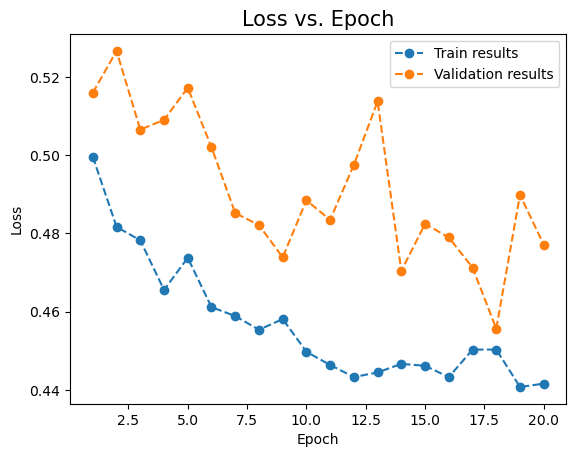

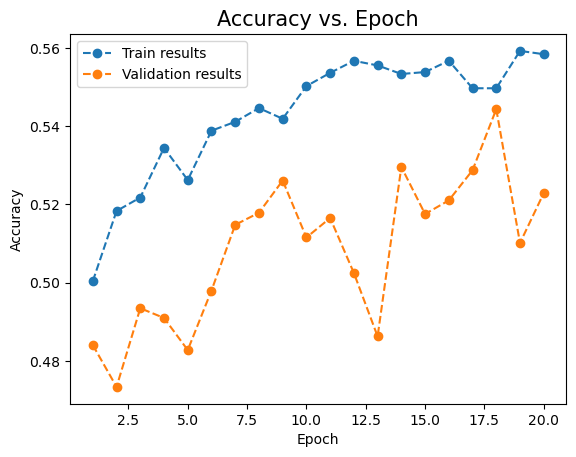

In [24]:
# run the training again
n_epochs = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # default LR -3
# TODO: remove the scheduler (see also above)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
metric = dice_score
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs, scheduler)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
# TODO: don't call it accuracy, it's the dice score!
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

/tmp/ipykernel_40370/89069472.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred).cpu().numpy().squeeze()


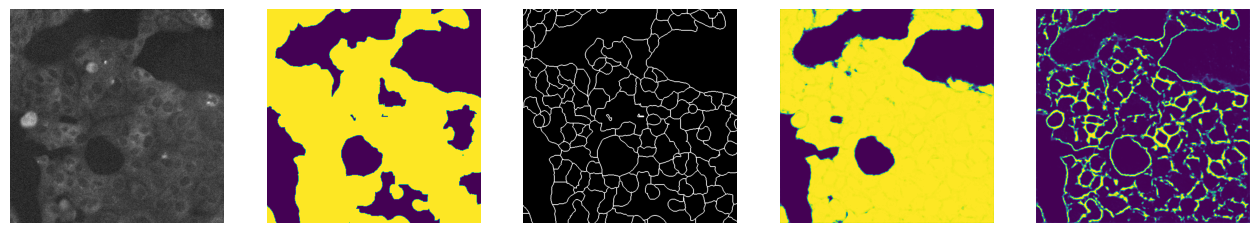

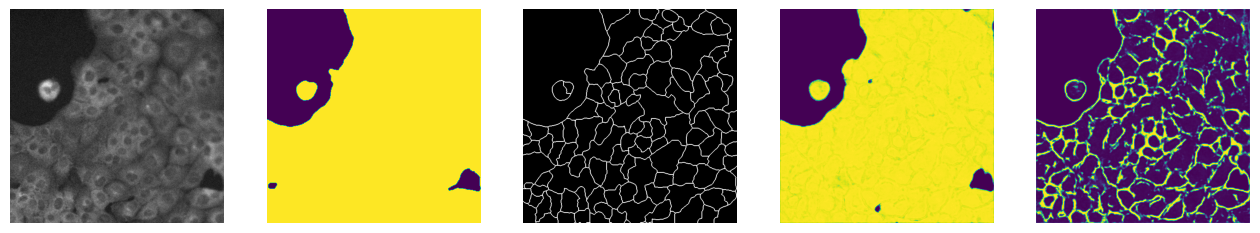

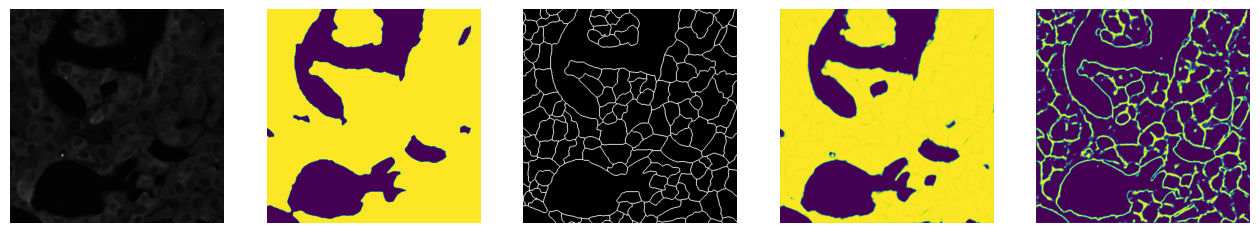

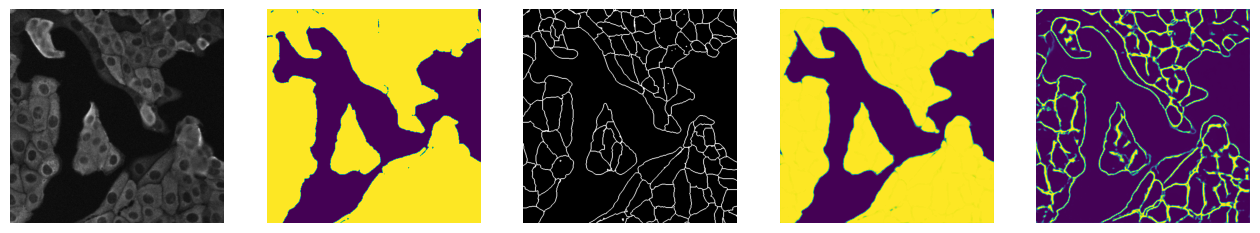

In [25]:
# TODO: use napari here. We should be consistent in using it for visualization.
# check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in test_loader:
        if counter > 3:
            break
        pred = model(im.to(device))
        pred = torch.tensor(pred).cpu().numpy().squeeze()
        fig, ax = plt.subplots(1, 5, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im.squeeze(), cmap="gray")
        ax[1].axis("off")
        ax[1].imshow(mask[0, 0], cmap="viridis")
        ax[2].axis("off")
        ax[2].imshow(mask[0, 1], cmap="gray")
        ax[3].axis("off")
        ax[3].imshow(pred[0]) 
        ax[4].axis("off")
        ax[4].imshow(pred[1]) 
        plt.show()
        counter += 1

In [ ]:
# TODO: now run the model for all images in the test set. Run for the full image and save the result.
# You may need to use padding to make some of the images fit the model (if yes, then remove the padding afterwards).
# Please save the predictions using a similar naming scheme as in the bioimageio nucleus segmentation exercise

## Possible Exercises

- Implement instance segmentation based on watershed from the instances. (This one we do for sure.)
- Validate the result with some metric

Advanced:
- Try with a larger U-Net
- Try different loss functions: CE, BCE, (with weighting)